## Réseau Maxout, avec epsilon = 0.25

Epoch [1/20], Loss: 0.35628538477574107
Epoch [2/20], Loss: 0.2832605241851108
Epoch [3/20], Loss: 0.3083498011270763
Epoch [4/20], Loss: 0.31100153710446876
Epoch [5/20], Loss: 0.31068999367649525
Epoch [6/20], Loss: 0.27526397176751355
Epoch [7/20], Loss: 0.2982578606126501
Epoch [8/20], Loss: 0.2972106563281978
Epoch [9/20], Loss: 0.29494506298436246
Epoch [10/20], Loss: 0.30964086499825083
Epoch [11/20], Loss: 0.2950220444068557
Epoch [12/20], Loss: 0.2684384090455543
Epoch [13/20], Loss: 0.25720469126655304
Epoch [14/20], Loss: 0.31790098370714304
Epoch [15/20], Loss: 0.2792730559316212
Epoch [16/20], Loss: 0.2713517146316053
Epoch [17/20], Loss: 0.2901061306199608
Epoch [18/20], Loss: 0.2654442465697744
Epoch [19/20], Loss: 0.27127410286814985
Epoch [20/20], Loss: 0.2567230215879559
Accuracy on adversarial examples: 66.59166666666667%
Average probability assigned to incorrect predictions: 99.99%


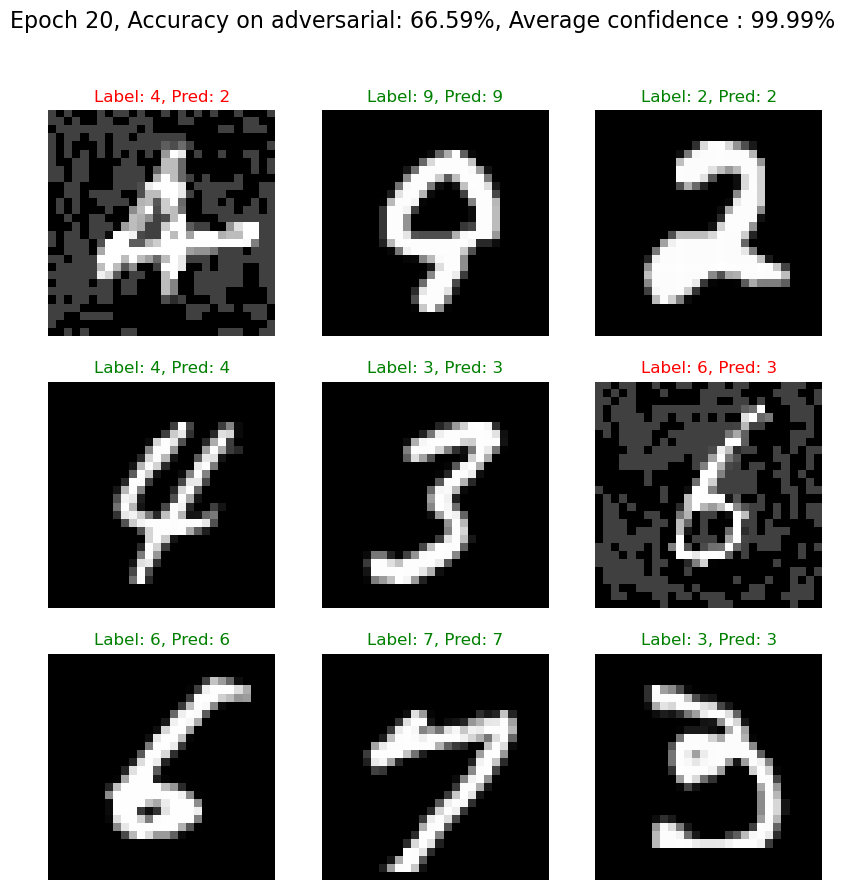

In [ ]:
# @title bonne version, Maxout Network avec epsilon = 0.25, et optimisateur : Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Classe du modèle: maxout
class MaxoutNN(nn.Module):
    def __init__(self, num_pieces=2):
        super(MaxoutNN, self).__init__()
        self.maxout1 = Maxout(28 * 28, 128, num_pieces)  
        self.maxout2 = Maxout(128, 10, num_pieces)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  
        x = self.maxout1(x)
        x = self.maxout2(x)
        return x

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()
        self.num_pieces = num_pieces
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        shape = x.size(0), self.out_features, self.num_pieces
        x = self.linear(x)
        x = x.view(*shape)
        return x.max(dim=2)[0]

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)

        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    train_loader = load_data()

    model = MaxoutNN(num_pieces=2)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_on_normal_data(model, train_loader, optimizer, epochs)

    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 0.41648553415084444
Epoch [2/20], Loss: 0.17484295763758453
Epoch [3/20], Loss: 0.12460868939884436
Epoch [4/20], Loss: 0.09887975427721228
Epoch [5/20], Loss: 0.08147864287762817
Epoch [6/20], Loss: 0.06886202018104319
Epoch [7/20], Loss: 0.059410179105859356
Epoch [8/20], Loss: 0.05185181591143486
Epoch [9/20], Loss: 0.045929410199481824
Epoch [10/20], Loss: 0.041083032106444525
Epoch [11/20], Loss: 0.03622730879454629
Epoch [12/20], Loss: 0.032208646201952566
Epoch [13/20], Loss: 0.029222137870208453
Epoch [14/20], Loss: 0.026090321039953734
Epoch [15/20], Loss: 0.02346011624447624
Epoch [16/20], Loss: 0.021085673728327294
Epoch [17/20], Loss: 0.019235765721439434
Epoch [18/20], Loss: 0.017513522996566198
Epoch [19/20], Loss: 0.015936301806187037
Epoch [20/20], Loss: 0.014463980600529754
Accuracy on adversarial examples: 1.2516666666666667%
Average probability assigned to incorrect predictions: 94.76%


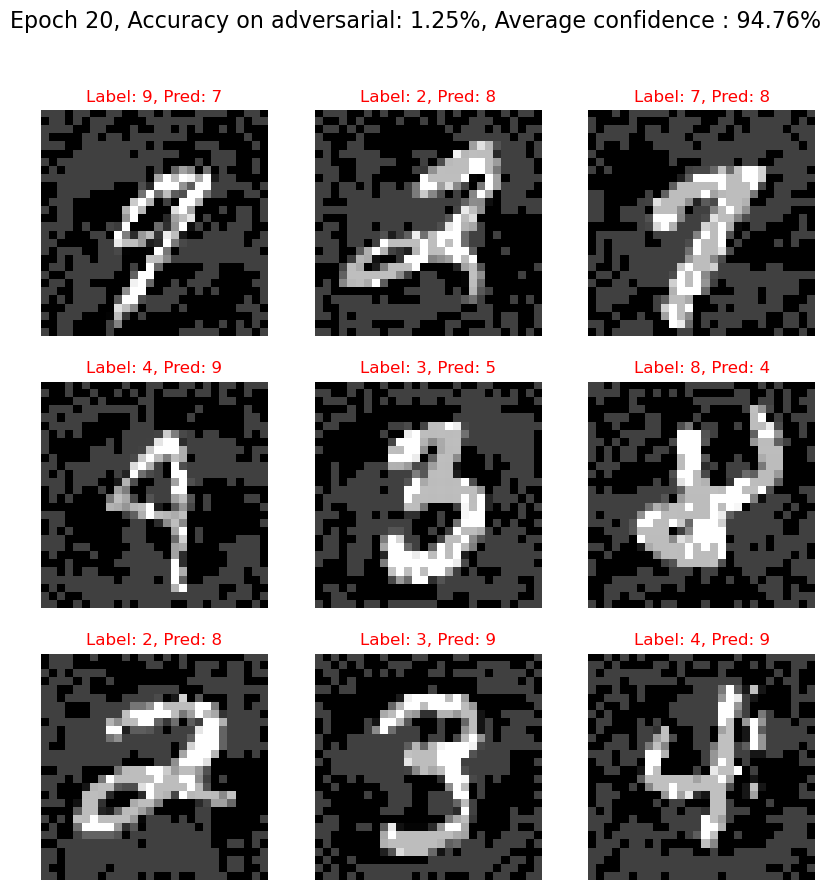

In [ ]:
# @title bonne version, Maxout Network avec epsilon = 0.25, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Classe du modèle: maxout
class MaxoutNN(nn.Module):
    def __init__(self, num_pieces=2):
        super(MaxoutNN, self).__init__()
        self.maxout1 = Maxout(28 * 28, 128, num_pieces)
        self.maxout2 = Maxout(128, 10, num_pieces)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.maxout1(x)
        x = self.maxout2(x)
        return x

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()
        self.num_pieces = num_pieces
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        shape = x.size(0), self.out_features, self.num_pieces
        x = self.linear(x)
        x = x.view(*shape)
        return x.max(dim=2)[0]

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)

        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    train_loader = load_data()

    model = MaxoutNN(num_pieces=2)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_on_normal_data(model, train_loader, optimizer, epochs)

    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()
